In [231]:
#export
from exp.nb_05b import *
import torch 
torch.set_num_threads(2)

# ConvNet

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

In [5]:
x_train.mean(),x_train.std()

(tensor(9.3006e-09), tensor(1.))

In [6]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self,func):
        super().__init__()
        self.func= func
    def forward(self,x): return self.func(x)

In [9]:
#export
def flatten(x): return x.view(x.shape[0],-1)
def mnist_resize(x): return x.view(-1,1,28,28)

In [10]:
x_train.shape

torch.Size([60000, 784])

In [11]:
mnist_resize(x_train).shape

torch.Size([60000, 1, 28, 28])

In [12]:
def get_cnn(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2),nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
        
    )

In [13]:
model = get_cnn(data)

In [14]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [15]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [16]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [26]:
%time run.fit(5, learn)

train: [0.0870561279296875, tensor(0.9737, device='cuda:0')]
valid: [0.118527734375, tensor(0.9609, device='cuda:0')]
train: [0.07697461751302083, tensor(0.9762, device='cuda:0')]
valid: [0.10361300048828125, tensor(0.9659, device='cuda:0')]
train: [0.072028466796875, tensor(0.9781, device='cuda:0')]
valid: [0.0884679443359375, tensor(0.9721, device='cuda:0')]
train: [0.06179755452473958, tensor(0.9809, device='cuda:0')]
valid: [0.09189302368164062, tensor(0.9722, device='cuda:0')]
train: [0.056440047200520836, tensor(0.9819, device='cuda:0')]
valid: [0.14008095703125, tensor(0.9563, device='cuda:0')]
CPU times: user 6.69 s, sys: 105 ms, total: 6.79 s
Wall time: 6.7 s


## CUDA

In [18]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [27]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [28]:
torch.cuda.set_device(device)

In [29]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [30]:
cbfs.append(CudaCallback)

In [31]:
model = get_cnn(data)

In [32]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [25]:
%time run.fit(5, learn)

train: [1.9631473958333334, tensor(0.3169, device='cuda:0')]
valid: [1.04209130859375, tensor(0.6501, device='cuda:0')]
train: [0.3782937174479167, tensor(0.8843, device='cuda:0')]
valid: [0.2015737060546875, tensor(0.9389, device='cuda:0')]
train: [0.16052291666666665, tensor(0.9520, device='cuda:0')]
valid: [0.12368642578125, tensor(0.9608, device='cuda:0')]
train: [0.12086544596354167, tensor(0.9639, device='cuda:0')]
valid: [0.20863896484375, tensor(0.9369, device='cuda:0')]
train: [0.12118295084635416, tensor(0.9637, device='cuda:0')]
valid: [0.1063416015625, tensor(0.9658, device='cuda:0')]
CPU times: user 9.05 s, sys: 1.33 s, total: 10.4 s
Wall time: 10.3 s


# Refactor Model

In [33]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [34]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [35]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [36]:
nfs = [8,16,32,32]

In [37]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [38]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [39]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [40]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [41]:
run.fit(3, learn)

train: [1.9156110677083333, tensor(0.3286, device='cuda:0')]
valid: [0.8875271484375, tensor(0.7289, device='cuda:0')]
train: [0.3323615234375, tensor(0.9006, device='cuda:0')]
valid: [0.324119189453125, tensor(0.9001, device='cuda:0')]
train: [0.17196749674479167, tensor(0.9476, device='cuda:0')]
valid: [0.1787380615234375, tensor(0.9424, device='cuda:0')]


# Hooks 

In [43]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [44]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f66303c2268>),
 __main__.CudaCallback,
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f655c5d3d90>)]

In [45]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [46]:
run.fit(2, learn)

train: [2.2920723958333333, tensor(0.1346, device='cuda:0')]
valid: [2.1009740234375, tensor(0.2049, device='cuda:0')]
train: [2.0540873697916666, tensor(0.2655, device='cuda:0')]
valid: [1.80435859375, tensor(0.4678, device='cuda:0')]


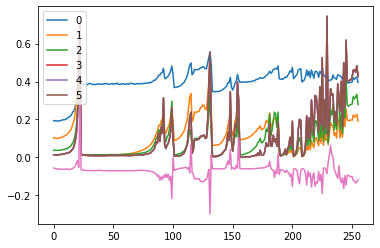

In [47]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

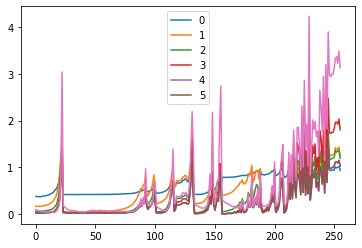

In [48]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

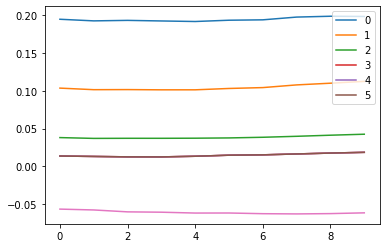

In [49]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

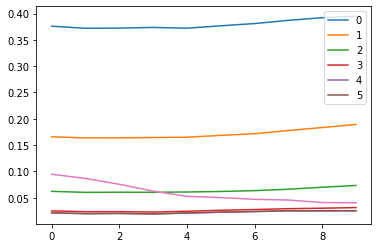

In [50]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

# PyTorch Hooks 

In [51]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [52]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [53]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [54]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [55]:
run.fit(1, learn)

train: [1.6549415364583333, tensor(0.4434, device='cuda:0')]
valid: [1.04619052734375, tensor(0.6389, device='cuda:0')]


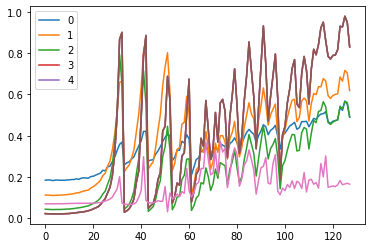

In [56]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

# Hook Class 

In [57]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [58]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [59]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [60]:
run.fit(1, learn)

train: [1.978671875, tensor(0.3200, device='cuda:0')]
valid: [0.98587568359375, tensor(0.6726, device='cuda:0')]


In [61]:
hooks[0].hook

In [62]:
hooks[0].hook

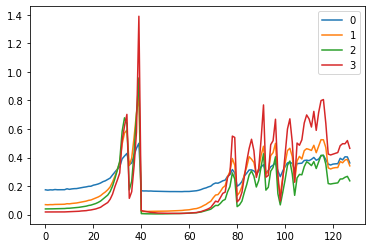

In [63]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

# Hooks Class 

In [64]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [65]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [66]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [67]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [68]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f655ee3fef0>, <__main__.Hook object at 0x7f655ee3fd68>, <__main__.Hook object at 0x7f6549700b00>, <__main__.Hook object at 0x7f6549737160>, <__main__.Hook object at 0x7f6549737208>, <__main__.Hook object at 0x7f65498abe48>, <__main__.Hook object at 0x7f65498abba8>]

In [69]:
hooks.remove()

In [70]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [71]:
x.mean(),x.std()

(tensor(-0.0072, device='cuda:0'), tensor(0.9912, device='cuda:0'))

In [72]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.2115, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3122, device='cuda:0', grad_fn=<StdBackward0>))

In [73]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [74]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.3810, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8581, device='cuda:0', grad_fn=<StdBackward0>))

train: [0.9492945963541667, tensor(0.6944, device='cuda:0')]
valid: [0.15102822265625, tensor(0.9554, device='cuda:0')]
train: [0.13300305989583333, tensor(0.9592, device='cuda:0')]
valid: [0.16983243408203125, tensor(0.9480, device='cuda:0')]


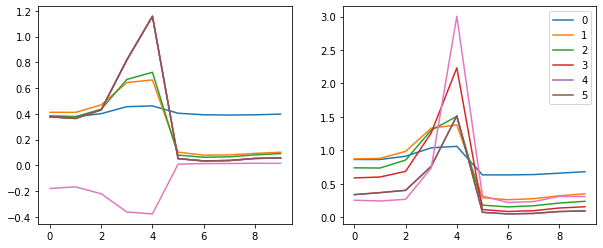

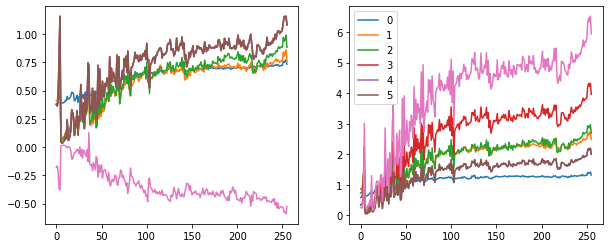

In [75]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [78]:
torch._ConvNd??

Object `torch._ConvNd` not found.


## Other Stats 

In [118]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[],[])
    means,stds,hists,percentile = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(200,0,10)) #histc isn't implemented on the GPU
    percentile.append({
        "5":outp.data.cpu().quantile(0.5),
        "15":outp.data.cpu().quantile(0.15),
        "50":outp.data.cpu().quantile(0.5),
        "85":outp.data.cpu().quantile(0.85),
        "95":outp.data.cpu().quantile(0.95),
    })

In [119]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [120]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [121]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.100605859375, tensor(0.6338, device='cuda:0')]
valid: [0.22834716796875, tensor(0.9314, device='cuda:0')]


In [108]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

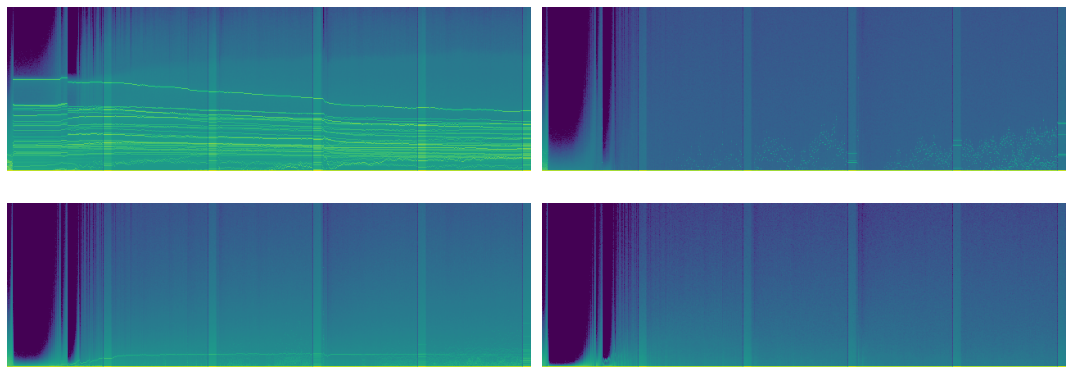

In [109]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [130]:
hooks[1].stats[3][:10]

[{'5': tensor(0.),
  '15': tensor(0.),
  '50': tensor(0.),
  '85': tensor(0.8120),
  '95': tensor(2.0291)},
 {'5': tensor(0.),
  '15': tensor(0.),
  '50': tensor(0.),
  '85': tensor(0.5599),
  '95': tensor(1.3587)},
 {'5': tensor(0.),
  '15': tensor(0.),
  '50': tensor(0.),
  '85': tensor(0.6223),
  '95': tensor(1.5020)},
 {'5': tensor(0.),
  '15': tensor(0.),
  '50': tensor(0.),
  '85': tensor(0.7288),
  '95': tensor(1.8328)},
 {'5': tensor(0.),
  '15': tensor(0.),
  '50': tensor(0.),
  '85': tensor(0.8841),
  '95': tensor(2.5299)},
 {'5': tensor(0.),
  '15': tensor(0.),
  '50': tensor(0.),
  '85': tensor(1.1912),
  '95': tensor(3.4515)},
 {'5': tensor(0.),
  '15': tensor(0.),
  '50': tensor(0.),
  '85': tensor(0.4862),
  '95': tensor(1.5822)},
 {'5': tensor(0.),
  '15': tensor(0.),
  '50': tensor(0.),
  '85': tensor(0.3694),
  '95': tensor(1.0009)},
 {'5': tensor(0.),
  '15': tensor(0.),
  '50': tensor(0.),
  '85': tensor(0.4403),
  '95': tensor(1.4077)},
 {'5': tensor(0.),
  '15': t

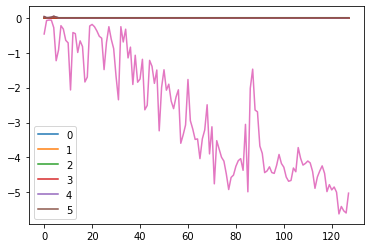

In [134]:
for h in hooks:
    plt.plot([it['15'] for it in h.stats[3]])
    h.remove()
plt.legend(range(6));

In [138]:
for idx,h in enumerate(hooks):
#     print(idx,pd.DataFrame(h.stats[3])['15'].mean())
    print(idx,pd.DataFrame(h.stats[3])['50'].mean())
    print(idx,pd.DataFrame(h.stats[3])['85'].mean())
    print(idx,pd.DataFrame(h.stats[3])['95'].mean())
    print('*************************************')
    

0 0.3607347309589386
0 1.5417227745056152
0 2.342529058456421
*************************************
1 0.0
1 0.5840601921081543
1 2.861973285675049
*************************************
2 0.0014282460324466228
2 0.42911607027053833
2 2.2987284660339355
*************************************
3 0.0009199624182656407
3 0.5753492116928101
3 3.8384528160095215
*************************************
4 0.02489812672138214
4 1.3077502250671387
4 2.797384262084961
*************************************
5 0.02489812672138214
5 1.3077502250671387
5 2.797384262084961
*************************************
6 0.08883250504732132
6 3.03947114944458
6 5.828917026519775
*************************************


In [165]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:10].sum(0)/h1.sum(0)

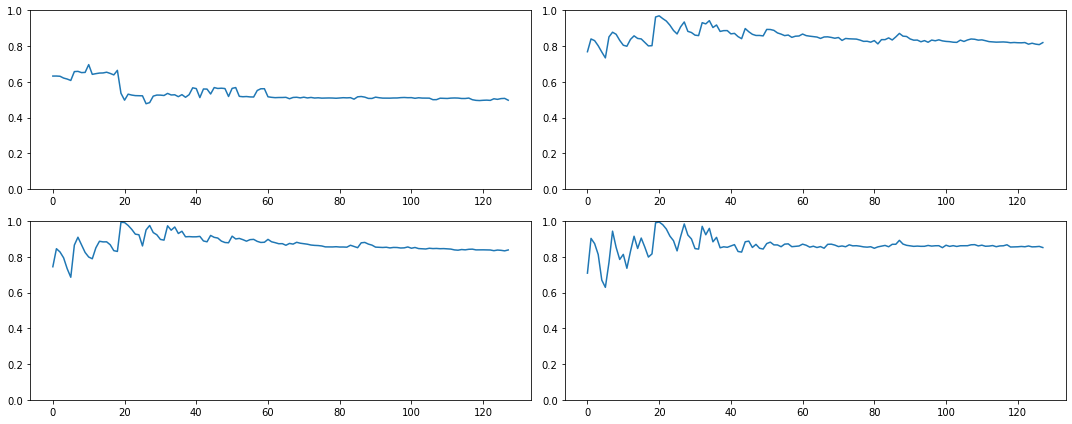

In [166]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [155]:
h1 = torch.stack(hooks[1].stats[2]).t().float()
(h1[:5].sum(0)/h1.sum(0))

tensor([0.6990, 0.7645, 0.7535, 0.7265, 0.7034, 0.6829, 0.7946, 0.8276, 0.8053,
        0.7719, 0.7602, 0.7459, 0.7894, 0.8206, 0.8012, 0.7945, 0.7811, 0.7538,
        0.7729, 0.9353, 0.9509, 0.9306, 0.9165, 0.8819, 0.8576, 0.8514, 0.8763,
        0.8944, 0.8506, 0.8594, 0.8463, 0.8437, 0.9047, 0.9008, 0.9125, 0.8762,
        0.8882, 0.8556, 0.8722, 0.8512, 0.8496, 0.8520, 0.8337, 0.8274, 0.8762,
        0.8584, 0.8454, 0.8365, 0.8427, 0.8424, 0.8787, 0.8784, 0.8709, 0.8536,
        0.8525, 0.8357, 0.8467, 0.8334, 0.8324, 0.8389, 0.8523, 0.8430, 0.8393,
        0.8367, 0.8347, 0.8275, 0.8268, 0.8311, 0.8290, 0.8177, 0.8315, 0.8106,
        0.8224, 0.8192, 0.8166, 0.8172, 0.8112, 0.8053, 0.8075, 0.8031, 0.8085,
        0.7954, 0.8109, 0.8091, 0.8310, 0.8109, 0.8313, 0.8566, 0.8366, 0.8320,
        0.8149, 0.8125, 0.8132, 0.8122, 0.8086, 0.8064, 0.8069, 0.8026, 0.8037,
        0.8089, 0.7938, 0.8030, 0.7941, 0.7997, 0.8064, 0.8050, 0.8084, 0.8181,
        0.8133, 0.8055, 0.8023, 0.8051, 

In [156]:
d = pd.DataFrame(hooks[4].stats[3])

In [160]:
d['85'].mean()

1.3077502250671387

In [158]:
d

,15,5,50,85,95
0,tensor(0.0331),tensor(0.3047),tensor(0.3047),tensor(0.7541),tensor(1.2518)
1,tensor(0.0024),tensor(0.1086),tensor(0.1086),tensor(0.2860),tensor(0.4277)
2,tensor(0.0054),tensor(0.1325),tensor(0.1325),tensor(0.3281),tensor(0.4896)
3,tensor(0.0153),tensor(0.1872),tensor(0.1872),tensor(0.4580),tensor(0.6804)
4,tensor(0.0425),tensor(0.3666),tensor(0.3666),tensor(0.9736),tensor(1.5363)
5,tensor(0.0185),tensor(0.5204),tensor(0.5204),tensor(1.6997),tensor(2.7290)
6,tensor(0.),tensor(0.1482),tensor(0.1482),tensor(0.6992),tensor(1.2448)
7,tensor(0.),tensor(0.0304),tensor(0.0304),tensor(0.2069),tensor(0.3971)
8,tensor(0.),tensor(0.0809),tensor(0.0809),tensor(0.4707),tensor(0.8996)
9,tensor(0.),tensor(0.1349),tensor(0.1349),tensor(0.8005),tensor(1.5835)


## Generalized Redlu

In [167]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [168]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [169]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.4427653645833333, tensor(0.8610, device='cuda:0')]
valid: [0.18560830078125, tensor(0.9402, device='cuda:0')]


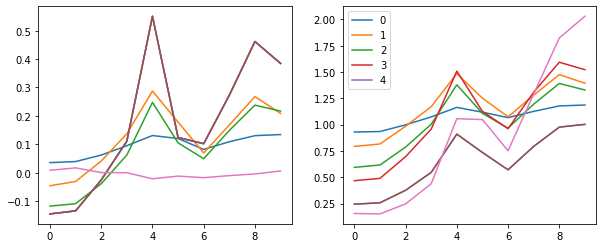

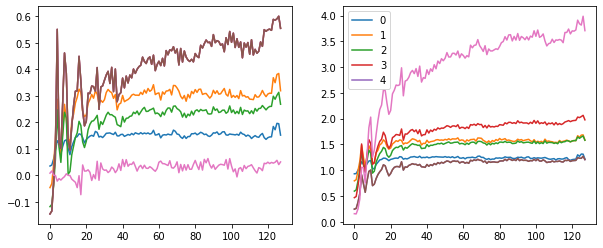

In [170]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

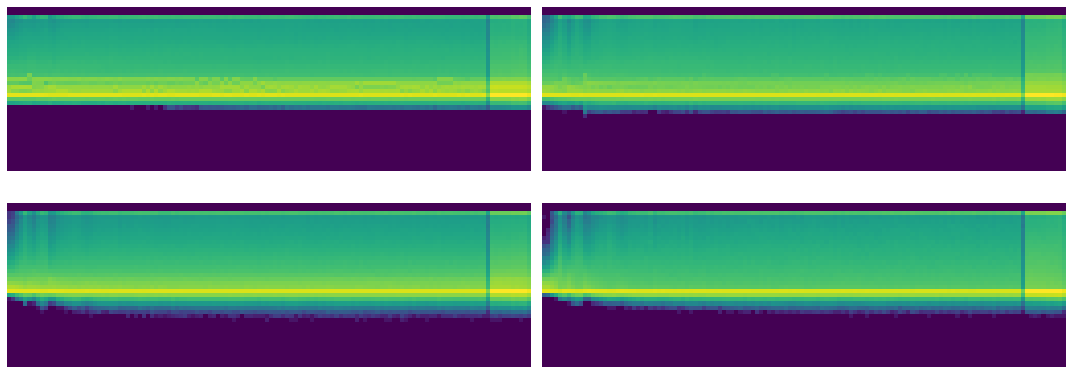

In [171]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [227]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

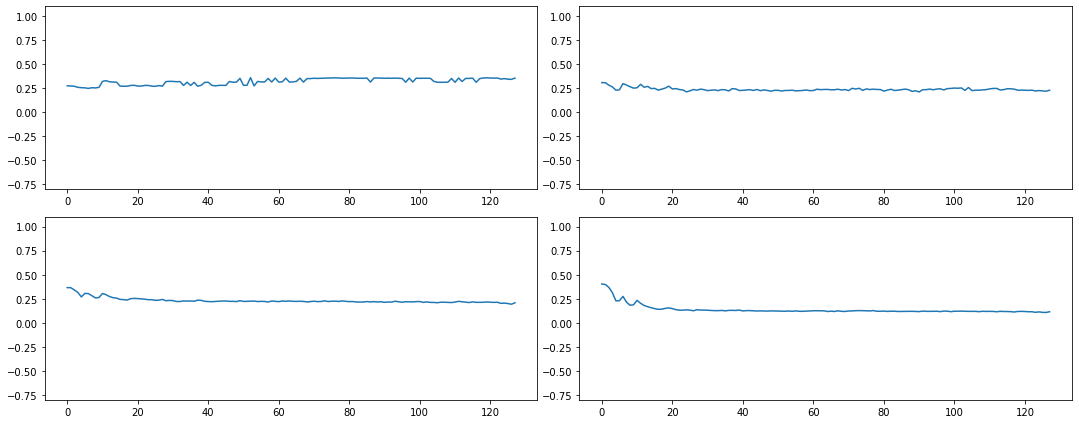

In [228]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(-0.8,1.1)
plt.tight_layout()

In [188]:
hooks[4].stats[2]

128

In [190]:
h1 = torch.stack(hooks[4].stats[2]).t().float()

In [193]:
h1.shape

torch.Size([40, 128])

In [197]:
h1[:20].sum(0)/h1.sum(0)

tensor([0.7578, 0.7427, 0.6190, 0.5250, 0.3341, 0.5574, 0.5081, 0.4648, 0.4111,
        0.4531, 0.5328, 0.5803, 0.5366, 0.5092, 0.4895, 0.5009, 0.4561, 0.4977,
        0.5370, 0.5460, 0.5474, 0.5045, 0.5200, 0.5056, 0.5078, 0.5120, 0.4996,
        0.5322, 0.5105, 0.5090, 0.5063, 0.4971, 0.4928, 0.5131, 0.4888, 0.5198,
        0.4836, 0.5366, 0.5158, 0.5152, 0.5005, 0.5078, 0.4916, 0.5065, 0.5004,
        0.4968, 0.4927, 0.4969, 0.4960, 0.4872, 0.4892, 0.4830, 0.4819, 0.4841,
        0.4817, 0.4784, 0.4869, 0.4755, 0.4933, 0.4873, 0.4804, 0.4857, 0.4708,
        0.4803, 0.4708, 0.4789, 0.4708, 0.4713, 0.4683, 0.4712, 0.4651, 0.4859,
        0.4679, 0.4780, 0.4703, 0.4709, 0.4827, 0.4875, 0.4775, 0.4817, 0.4714,
        0.4755, 0.4769, 0.4668, 0.4641, 0.4689, 0.4618, 0.4550, 0.4645, 0.4630,
        0.4520, 0.4561, 0.4579, 0.4528, 0.4654, 0.4613, 0.4624, 0.4474, 0.4575,
        0.4391, 0.4531, 0.4470, 0.4623, 0.4463, 0.4670, 0.4491, 0.4693, 0.4442,
        0.4495, 0.4482, 0.4670, 0.4435, 

In [229]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [236]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == 2: idx = 1
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [237]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [238]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [239]:
run.fit(8, learn)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


train: [0.9844652994791666, tensor(0.6847, device='cuda:0')]
valid: [0.424820751953125, tensor(0.8789, device='cuda:0')]
train: [0.2792759765625, tensor(0.9157, device='cuda:0')]
valid: [0.3057871826171875, tensor(0.9067, device='cuda:0')]
train: [0.192042333984375, tensor(0.9422, device='cuda:0')]
valid: [0.31591904296875, tensor(0.9063, device='cuda:0')]
train: [0.5937038411458333, tensor(0.8120, device='cuda:0')]
valid: [0.132205517578125, tensor(0.9585, device='cuda:0')]
train: [0.13480187174479166, tensor(0.9592, device='cuda:0')]
valid: [0.1242291259765625, tensor(0.9619, device='cuda:0')]
train: [0.07398751627604166, tensor(0.9775, device='cuda:0')]
valid: [0.06554049072265625, tensor(0.9801, device='cuda:0')]
train: [0.05485177001953125, tensor(0.9832, device='cuda:0')]
valid: [0.0564564697265625, tensor(0.9829, device='cuda:0')]
train: [0.04603453776041667, tensor(0.9862, device='cuda:0')]
valid: [0.05449637451171875, tensor(0.9833, device='cuda:0')]


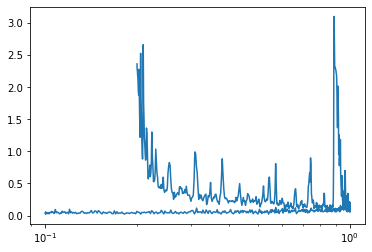

In [244]:
run.recorder.plot()

In [245]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [247]:
!python notebook2script.py 06_cuda_cnn_hooks.ipynb

Converted 06_cuda_cnn_hooks.ipynb to exp/nb_06.py
